# Adversarial Example - C&W攻撃編-

C and W攻撃は以下の最適化問題を解くことで、Adversarial Example x'を生成します。

$$
min_{x'} \quad \|x' - x\|_2^2 + c \cdot f(x')
$$
第一項と第二項についてそれぞれ意味を持っています。
- 第一項は、Adversarial Example x'が元の画像xと似ていることを意味しています。
- 第二項は、Adversarial Example x'が誤認識されにくさを意味しています。(詳細は後述)

cは定数、fは以下のように定義されます。
$$
f(x') = max(max\{Z(x')_i : i \neq t\} - Z(x')_t, -\kappa)
$$

今回簡単のため、$\kappa = 0$としましょう。すると
$$
f(x') = max(max\{Z(x')_i : i \neq t\} - Z(x')_t,0)
$$

となります。Z(x')は、Adversarial Example x'に対するモデルの出力を意味します。これが、攻撃して誤らせたいクラスの確率よりも大きくなるように、Adversarial Example x'を生成します。

x'は、元の画像xと似ていることを意味する第一項と、誤認識されにくさを意味する第二項のバランスを取りながら生成されます。cが大きいほど、第二項の影響が大きくなり、誤認識されにくい画像が生成されます。

さて、x'は画像なので0から1の範囲を取る必要があります。そこで、x'を以下のようにします。
$$
x’ = \frac{1}{2}(\tanh(w) + 1)
$$

このようにすることで、wの成分の値によらず、x'は0から1の範囲を取ることができます。

以上を踏まえて、C and W攻撃を実装してみましょう。
cとwが未決定の値です。次のように決定します。

- c: 二分探索
- w: Adam
  
cを一つ決める→wでの最適化、結果比較→cを更新→wでの最適化、結果比較→...という手順で最適化を行います。

まずはcを固定して見ましょう。

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #return F.log_softmax(x, dim=1)
        return (F.log_softmax(x, dim=1),x)

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=1, shuffle=True)

use_cuda = True# cuda使いたくないとき、Falseにすると強制的にCPUで計算される
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available())else "cpu")
#print(device)

model = Net().to(device)

model.load_state_dict(torch.load(pretrained_model,map_location='cpu'))

model.eval()# 推論を有効に

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

success
9->1
success
7->1
success
0->1
success
8->1
success
2->1
success
9->1
success
0->1
success
2->1
success
2->1
success
3->1
success
4->1
success
6->1
success
7->1
success
3->1
success
7->1
success
9->1
success
2->1
success
3->1
success
2->1
success
6->1
success
7->1
success
4->1
success
8->1
success
6->1
success
5->1
success
4->1
success
4->1
success
5->1
success
4->1
success
0->1
success
9->1
success
7->1
success
2->1
success
5->1
success
3->1
success
9->1
success
6->1
success
7->1
success
8->1
success
7->1
success
9->1
success
8->1
success
9->1
success
7->1
success
9->1
success
8->1
success
2->1
success
0->1
success
8->1
success
3->1
success
0->1
success
4->1
success
6->1
success
9->1
success
7->1
success
8->1
success
2->1
success
5->1
success
5->1
success
2->1
success
7->1
success
4->1
success
4->1
success
0->1
success
9->1
success
4->1
success
8->1
success
2->1
success
4->1
success
2->1
success
6->1
success
5->1
success
3->1
success
3->1
success
4->1
success
5->1
success
7->1

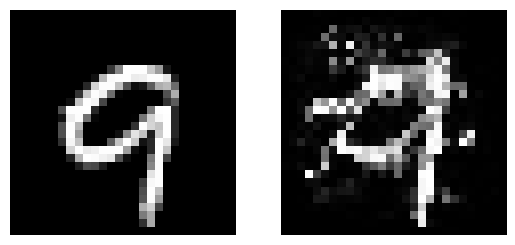

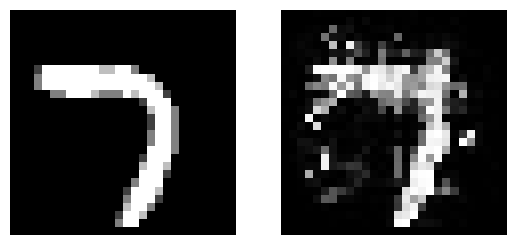

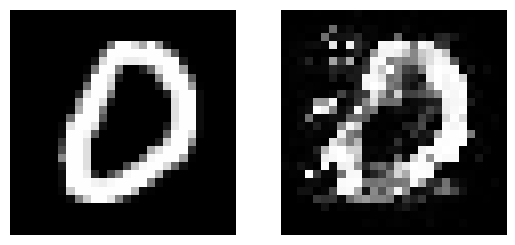

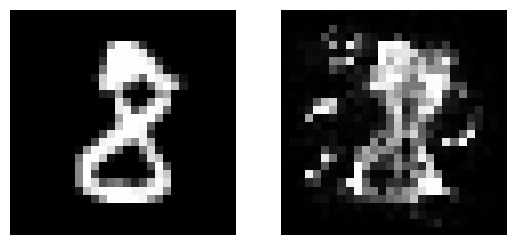

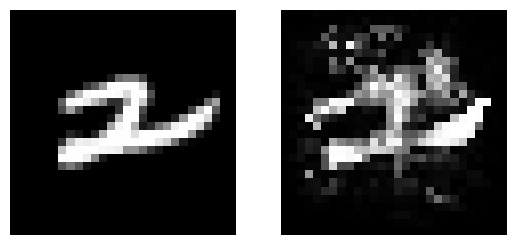

In [10]:
# モデルの定義

adv_model = lambda x: 1/2 * (torch.tanh(x) + 1)

# 目的関数
def target_function(x_adv, x, target_class, c):
    
    L2_norm = torch.norm(x_adv - x, p=2)

    # target_class以外のlogitの最大値を返す
    _, n_logit = model(x_adv)
    logit_max = torch.max(n_logit[0]-n_logit[0][target_class])
    loss = L2_norm + c * logit_max
    return loss




# 学習の実行
TARGET_CLASS = 1
CONST_C = 1
MAX_ITER = 1000
n_data = 0
n_success = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    if model(data)[0].argmax() == TARGET_CLASS:
        continue
    iter = 0
    n_data += 1
    # オプティマイザの定義
    w = torch.zeros(1, 1, 28, 28, requires_grad=True)
    optimizer = optim.Adam([w], lr=0.01)
    while(iter < MAX_ITER):
        optimizer.zero_grad()  
        perturbation= adv_model(w).to(device)  
        loss = target_function(perturbation, data, TARGET_CLASS, CONST_C)  # 損失
        loss.backward()  
        optimizer.step() 
        iter += 1
        if model(perturbation)[0].argmax() == TARGET_CLASS:
            n_success += 1
            print('success')
            print(f'{target[0]}->{model(perturbation)[0].argmax()}')
            if n_success <=5:
            
                fig, axis = plt.subplots(nrows=1, ncols=2)
                original_img = data.cpu().detach().numpy()
                # 1つ目の軸に画像を表示する
                axis[0].imshow(original_img[0][0],cmap='gray')
                
                axis[0].axis("off")

                perturbation_img = perturbation.cpu().detach().numpy()

                axis[1].imshow(perturbation_img[0][0],cmap='gray')
                axis[1].axis("off")
            
            break
    if n_data == 100:
        print(n_success/n_data)
        break
        
    
